In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
import pickle
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
repo_dir = Path('../..')

In [4]:
if str(repo_dir) not in sys.path:
    sys.path.append(str(repo_dir))
    
from analysis.curve_fitting.src.fitting_functions import LOSS_FUNCTIONS
from analysis.curve_fitting.src.utils import apply_filters, load_yaml, convert_loss_parameters, convert_loss_parameters_batch

from visualization.src.utils import COLOR_PALETTES, set_ticks, save_figs
from visualization.src.visualize import plot_reg, plot_reg_bivariate, plot_confidence_intervals



In [5]:
args = {
    'results_csv': repo_dir / 'results' / 'benchmark_scores_local.csv',
}

In [6]:
results_csv = args['results_csv']

df_results = pd.read_csv(results_csv)
df_results['total_flops'] = df_results['flops'] * df_results['n_samples_seen']

## Load Experiment Configuration

In [7]:
config = {
    'data_filters': {
        'set_filters': {
            'region': [
                'V1',
                'V2',
                'V4',
                'IT',
                'Behavioral'
                ],
            'dataset': [
                'imagenet',
                'ecoset',
                ]
            },
    'boolean_filters': {
        'equals_false': [
            'is_pretrained',
            'is_random',
            'is_ssl',
            'is_adv',
            'is_ablation'
            ]
        },
    
    'group_by': {
        'avg_score': {
            'keys': [
                'model_id',
                'arch',
                'dataset',
                'flops',
                'n_params',
                'n_samples',
                'n_samples_seen',
                'total_flops',
                'arch_family',
                'samples_per_class'
            ],
            'reduce': {'score': 'mean'}}},
    # 'arch_families_samples': {
    #     'arch_family': [
    #         'ConvNeXt',
    #         'ConvNeXtFlex',
    #         'ViT',
    #         'ViTFlex',
    #         ],
    # 'samples_per_class': [0, 300]},
    'combine_arch_families': True,
    }
}

## Apply Data Filters

In [8]:
df = apply_filters(df_results, config.get('data_filters', {}))

## Visualize

#### Plotting settings

In [9]:
linewidth = 3.0
alpha_scatter = 0.2
alpha_ci = 0.2
alpha_fit = 1.0
fig_multiplier = 0.75
figsize = (10, 8)
figsize = (fig_multiplier * figsize[0], fig_multiplier * figsize[1])

color_palaette = COLOR_PALETTES['models']

arch2colorid = {
    'ResNet': 5,
    'EfficientNet': 4,
    'ConvNeXt': 2,
    'ViT': 3,
    'CorNet-S': 1,
    'AlexNet': 0,
}

#### Plot

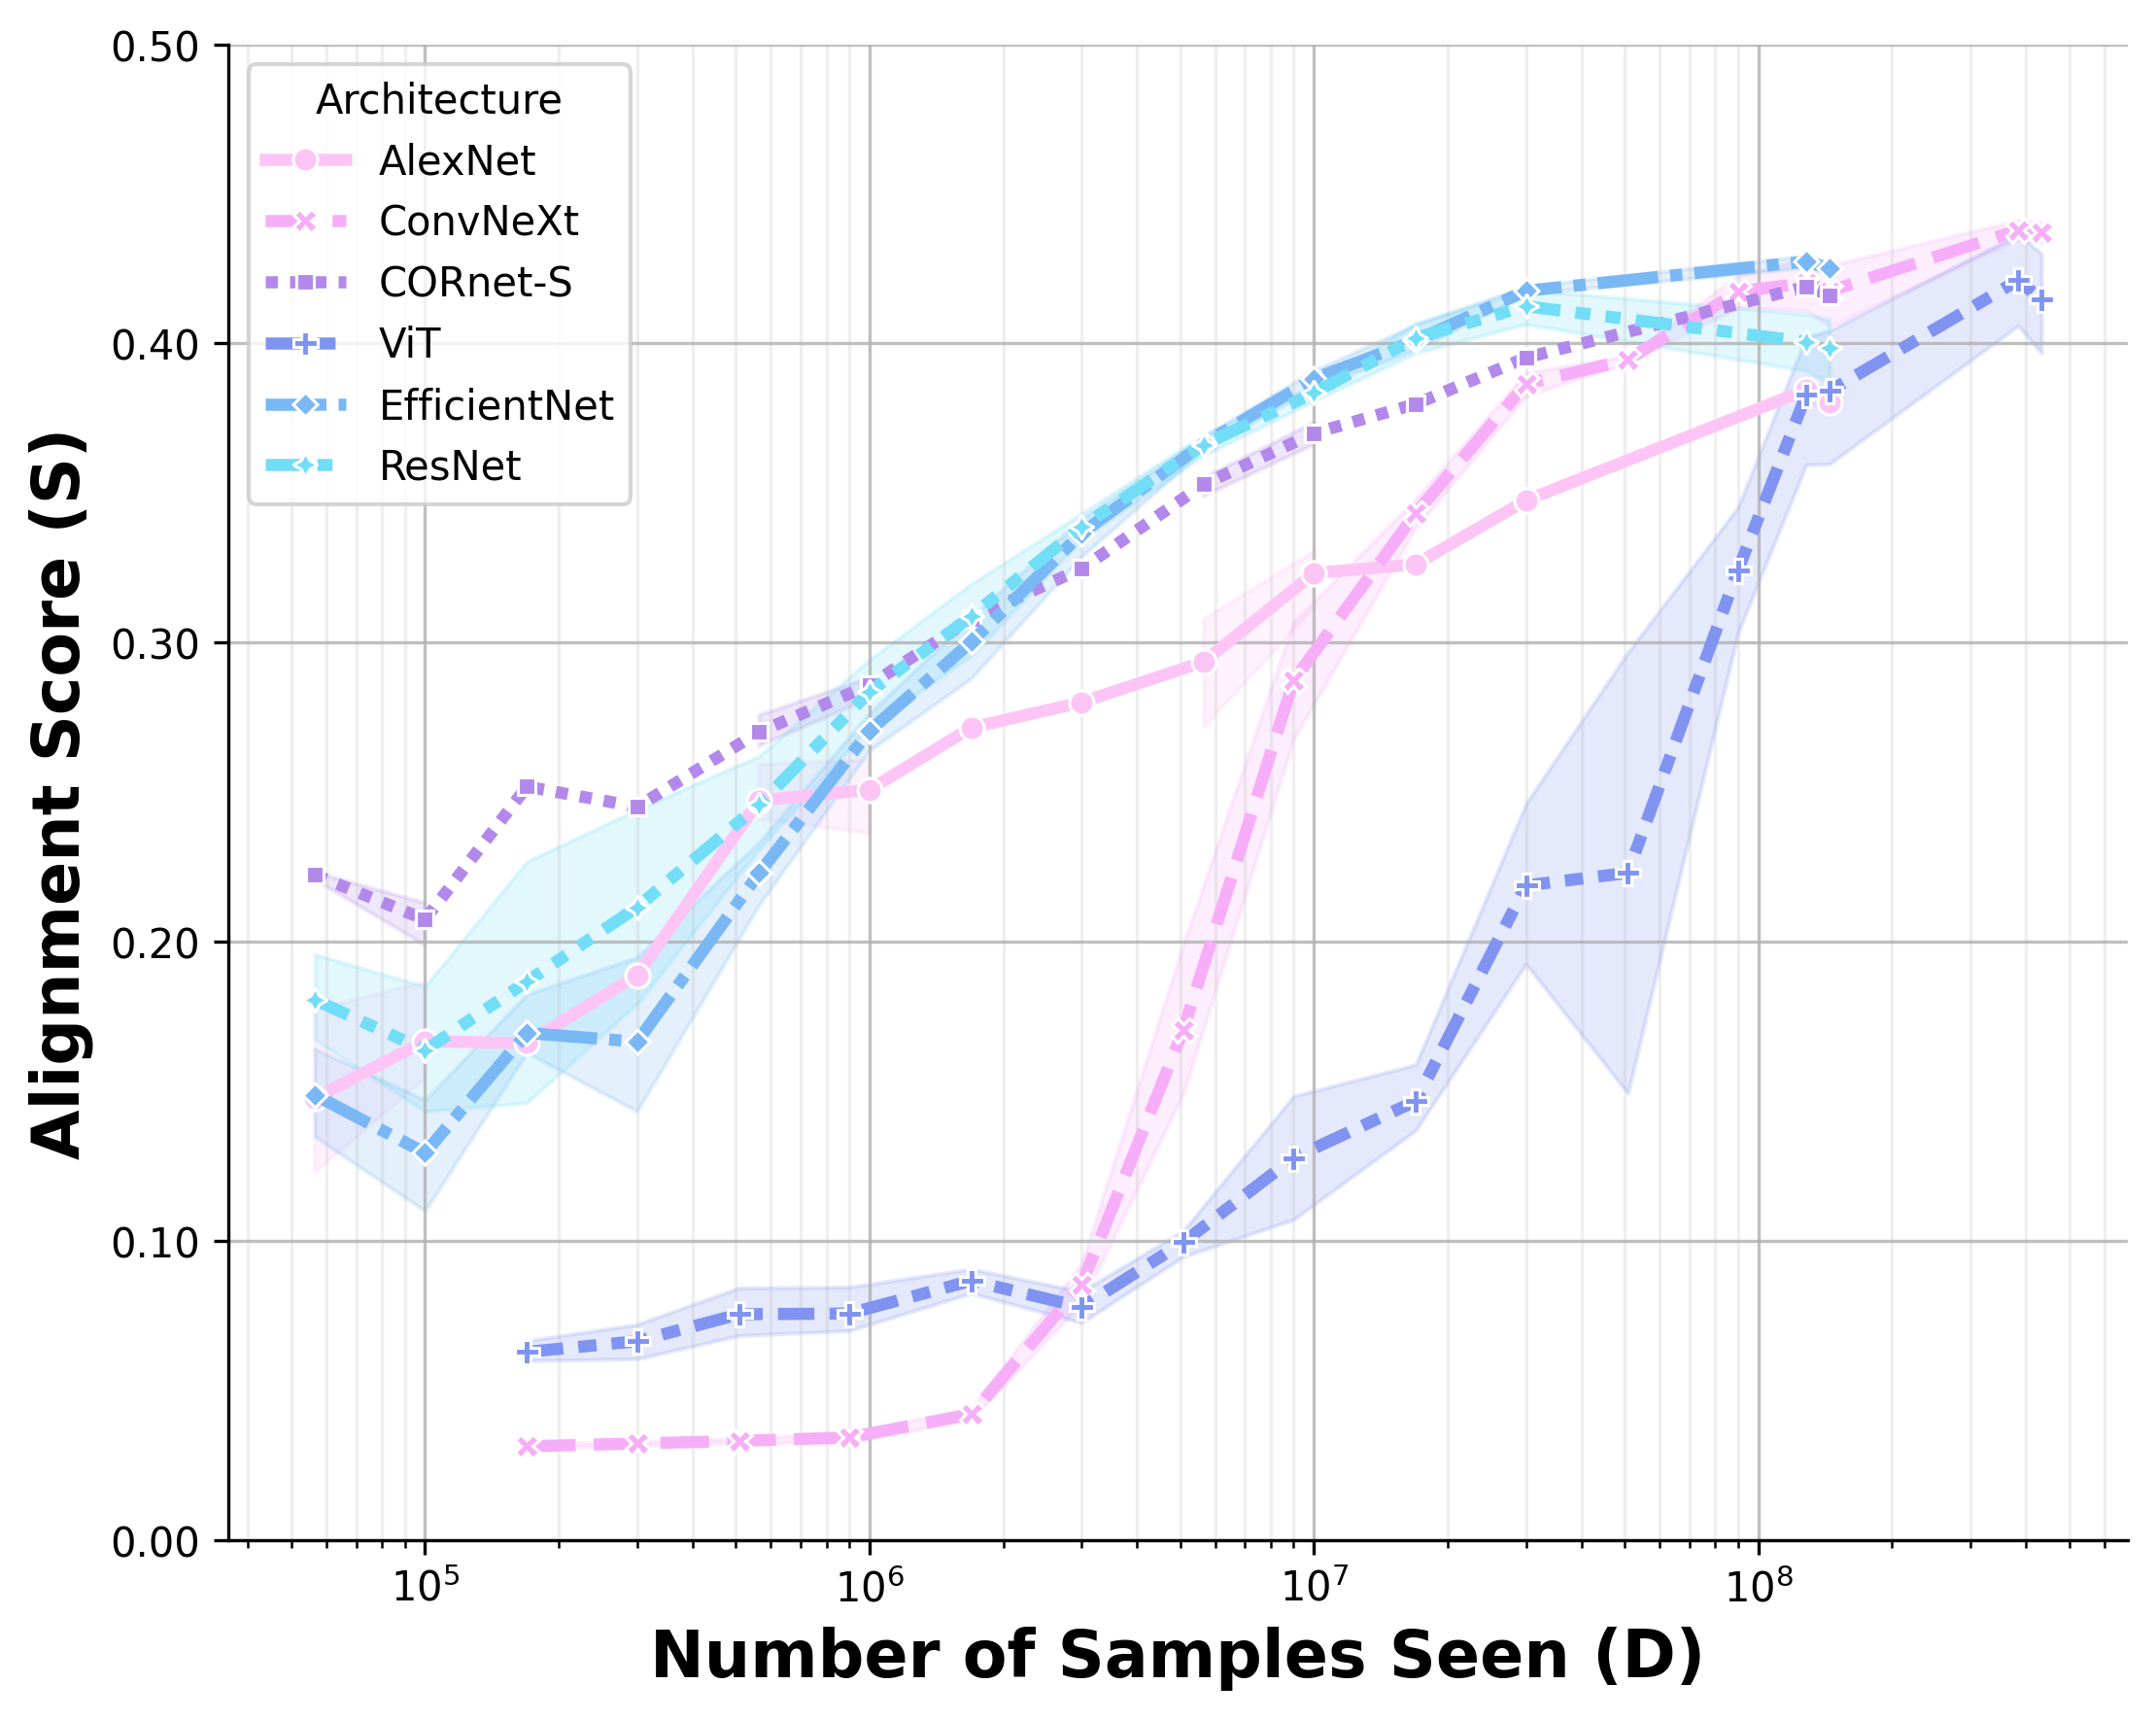

In [10]:
# sns.set_theme(style='whitegrid')
# sns.set_theme(style='ticks')


fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=300)
ax = axes

df_plot = df.copy()
df_plot.rename(columns={'arch_family': 'Architecture'}, inplace=True)


sns.lineplot(data=df_plot, x='n_samples_seen', y='score', ax=ax, hue='Architecture', style='Architecture', markers=True, palette=color_palaette, linewidth=linewidth)


ax.set_xscale('log')
ax.set_xlabel('Number of Samples Seen (D)', fontsize=16, fontweight='bold')
ax.set_ylabel('Alignment Score (S)', fontsize=16, fontweight='bold')
# ax.set_title(arch_family, fontsize=20, fontweight='bold')
ax = set_ticks(ax, xticks_mode='log', yticks_mode=None, yticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])


ax.spines[['right', 'top']].set_visible(False)

# break
plt.tight_layout()


figures_dir = '../figures'
fig_name = 'fig3_sample_eff'
formats = ['pdf', 'png', 'svg']
save_figs(figures_dir, fig_name, formats=formats)